In [1]:
%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_row', 500)
pd.set_option('display.max_colwidth', 200)

# Introduction 

This notebook explains how the various implemented binning strategies of `PyRisk` work.  
First, we import all binning strategies:

In [2]:
from pyrisk.binning import AgglomerativeBucketer, SimpleBucketer, QuantileBucketer

Let's create some data on which we want to apply the binning strategies. We choose a logistic function because it clearly supports the explanation on how binning strategies work. Moreover, the typical reliability curve for a trained random forest model has this shape and binning strategies could be used for probability calibration (see also the website of Scikit-learn on [probability calibration](https://scikit-learn.org/stable/modules/calibration.html)).

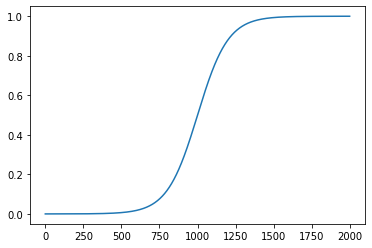

In [3]:
def log_function(x):
    return 1/(1+np.exp(-x))

x = [log_function(x) for x in np.arange(-10,10,0.01)]

plt.plot(x);

## Simple binning

The `SimpleBucketer` object creates binning of the values in `x` into equally sized bins. The attributes `counts`, the number of elements per bin, and `boundaries`, the actual boundaries that resulted from the binning strategy are assigned to the object instance. In this example we choose to get 4 bins:

In [4]:
mySimpleBucketer = SimpleBucketer(bin_count=4)
mySimpleBucketer.fit(x)
print('counts', mySimpleBucketer.counts)
print('boundaries', mySimpleBucketer.boundaries)

counts [891 109 110 890]
boundaries [4.53978687e-05 2.50022585e-01 4.99999772e-01 7.49976959e-01
 9.99954146e-01]


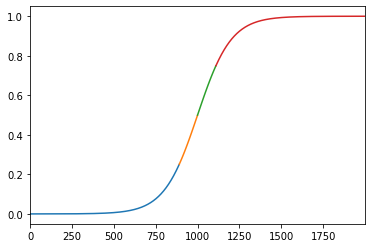

In [5]:
df = pd.DataFrame({'x':x})
df['label'] = pd.cut(x, bins=mySimpleBucketer.boundaries, include_lowest=True)

fig, ax = plt.subplots()
for label in df.label.unique():
    df[df.label==label].plot(ax=ax, y='x', legend=False)

As can be seen, the number of elements in the tails of the data is larger than in the middle:

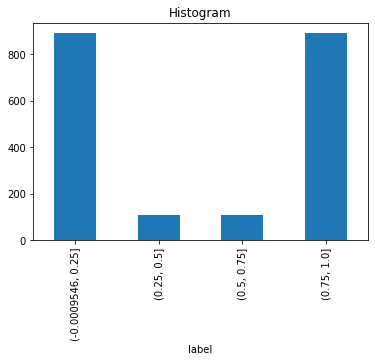

In [6]:
df.groupby('label')['x'].count().plot(kind='bar');
plt.title('Histogram');

## Quantile binning 

The `QuantileBucketer` object creates bins that all contain an equal amount of samples

In [7]:
myQuantileBucketer = QuantileBucketer(bin_count=4)
myQuantileBucketer.fit(x)
print('counts', myQuantileBucketer.counts)
print('boundaries', myQuantileBucketer.boundaries)

counts [500 500 500 500]
boundaries [4.53978687e-05 6.67631251e-03 4.98750010e-01 9.93257042e-01
 9.99954146e-01]


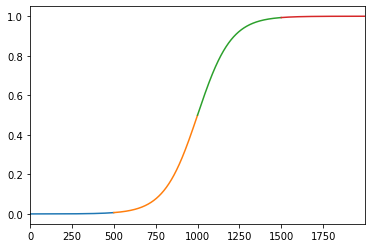

In [8]:
df = pd.DataFrame({'x':x})
df['label'] = pd.cut(x, bins=myQuantileBucketer.boundaries, include_lowest=True)

fig, ax = plt.subplots()
for label in df.label.unique():
    df[df.label==label].plot(ax=ax, y='x', legend=False)

As can be seen, the number of elements is the same in all bins:

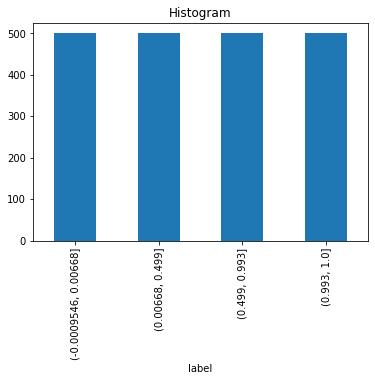

In [9]:
df.groupby('label')['x'].count().plot(kind='bar');
plt.title('Histogram');

## Binning by agglomerative clustering

The `AgglomerativeBucketer` class applies the Scikit-Learn `AgglomerativeClustering` algorithm to the data and uses the clusters to determine the bins.
We use different data to show the value of this algoritm; we create the following distribution:

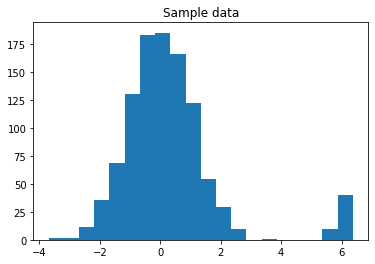

In [10]:
x_agglomerative = np.append(np.random.normal(0,1,size=1000), np.random.normal(6,0.2,size=50))
plt.hist(x_agglomerative, bins=20);
plt.title('Sample data');

When we apply the `AgglomerativeBucketer` algorithm with 2 bins, we see that the algorithm nicely creates a split in between the two centers

In [11]:
myAgglomerativeBucketer = AgglomerativeBucketer(bin_count=2)
myAgglomerativeBucketer.fit(x_agglomerative)
print('counts', myAgglomerativeBucketer.counts)
print('boundaries', myAgglomerativeBucketer.boundaries)

counts [1000   50]
boundaries [-3.6956033164872766, 4.436430816792079, 6.37615931614815]


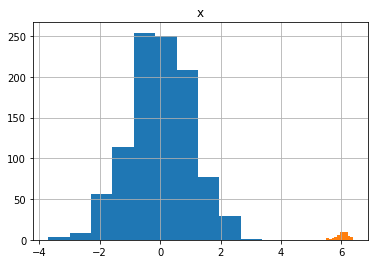

In [12]:
df = pd.DataFrame({'x':x_agglomerative})
df['label'] = pd.cut(x_agglomerative, bins=myAgglomerativeBucketer.boundaries, include_lowest=True)

fig, ax = plt.subplots()
for label in df.label.unique():
    df[df.label==label].hist(ax=ax)

Note that the `SimpleBucketer` strategy would just have created a split in the middle of the maximum and the minimum (at about 1.75). The `QuantileBucketer` strategy had created two bins with equal amount of elements in it, resulting in a split at around 0.

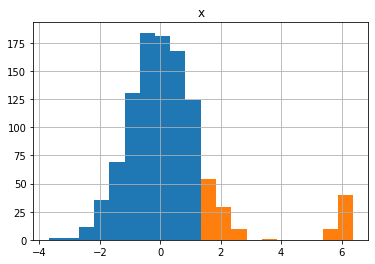

In [13]:
counts_agglomerative_simple, boundaries_agglomerative_simple = SimpleBucketer.simple_bins(x_agglomerative, 2)

df = pd.DataFrame({'x':x_agglomerative})
df['label'] = pd.cut(x_agglomerative, bins=boundaries_agglomerative_simple, include_lowest=True)

fig, ax = plt.subplots()
for label in df.label.unique():
    df[df.label==label].hist(ax=ax)

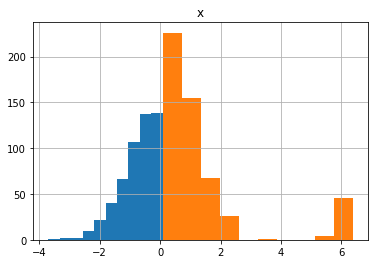

In [14]:
counts_agglomerative_quantile, boundaries_agglomerative_quantile = QuantileBucketer.quantile_bins(x_agglomerative, 2)

df = pd.DataFrame({'x':x_agglomerative})
df['label'] = pd.cut(x_agglomerative, bins=boundaries_agglomerative_quantile, include_lowest=True)

fig, ax = plt.subplots()
for label in df.label.unique():
    df[df.label==label].hist(ax=ax)